In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from numpy import *
%matplotlib notebook

In [2]:
cd cc2/

/home/selimb/School/repo/mech546/project1/truss/cc2


In [3]:
U = np.loadtxt('U.out', delimiter=',')
S = np.loadtxt('S.out', delimiter=',')
all_node_locs = np.loadtxt('node_locs.csv', skiprows=1, delimiter=',')
num_nodes = len(all_node_locs)
connectivity = np.loadtxt('connectivity.csv', skiprows=1, delimiter=',', dtype=int)
connectivity = connectivity - 1
num_elems = len(connectivity)
ndims = 3

In [4]:
def mk_sctr(nodeIDs):
    sctr = []
    for I in nodeIDs:
        dofs = [ndims*I + i for i in range(ndims)]
        sctr = sctr + dofs
    return sctr

In [5]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [6]:
def mk_beams(ax, locs, color=None):
    if color is None:
        ax.plot(locs[:,0], locs[:,1], locs[:,2], 'k--', ms=4)
    else:
        ax.plot(locs[:,0], locs[:,1], locs[:,2], lw=4, ms=4, color=color)

def mk_arrows(ax, all_node_locs, do_x=True, do_y=True, do_z=True):
    lw = 0.7
    arrowstyle = '-|>'
    color = 'k'
    mut_scale = 15

    xmax = np.max(all_node_locs[:,0])
    ymax = np.max(all_node_locs[:,1])
    zmax = np.max(all_node_locs[:,2])
    
    if do_x:
        x, y, z = [0, xmax*1.2], [0, 0], [0, 0]
        a = Arrow3D(x, y, z, mutation_scale=mut_scale, lw=lw, arrowstyle=arrowstyle, color=color)
        ax.add_artist(a)
        ax.text(x[1]*1.05, y[1], z[1], 'x', ha='center', va='center')

    if do_y:
        x, y, z = [0, 0], [0, ymax*1.2], [0, 0]
        a = Arrow3D(x, y, z, mutation_scale=mut_scale, lw=lw, arrowstyle=arrowstyle, color=color)
        ax.add_artist(a)
        ax.text(x[1], y[1]*1.05, z[1], 'y', ha='center', va='center')
        
    if do_z:
        x, y, z = [0, 0], [0, 0], [0, zmax*1.1]
        a = Arrow3D(x, y, z, mutation_scale=mut_scale, lw=lw, arrowstyle=arrowstyle, color=color)
        ax.add_artist(a)
        ax.text(x[1], y[1], z[1]*1.05, 'z', ha='center', va='center')

In [24]:
def sgn_map(S):
    cm = {-1: 'r', 1: 'b'}
    sgn = np.sign(S)
    return cm[sgn]

<IPython.core.display.Javascript object>


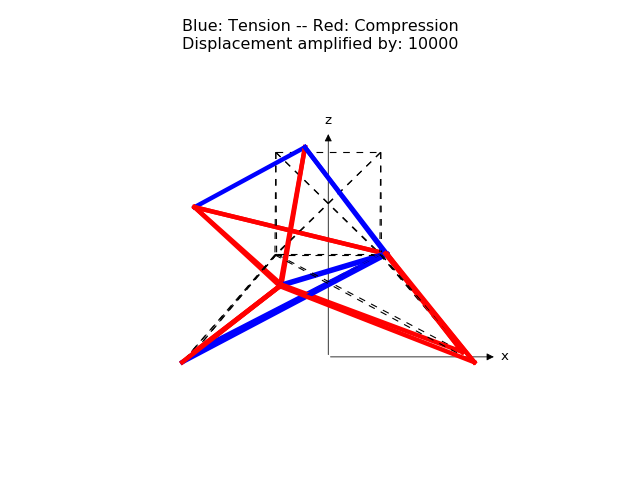

<IPython.core.display.Javascript object>


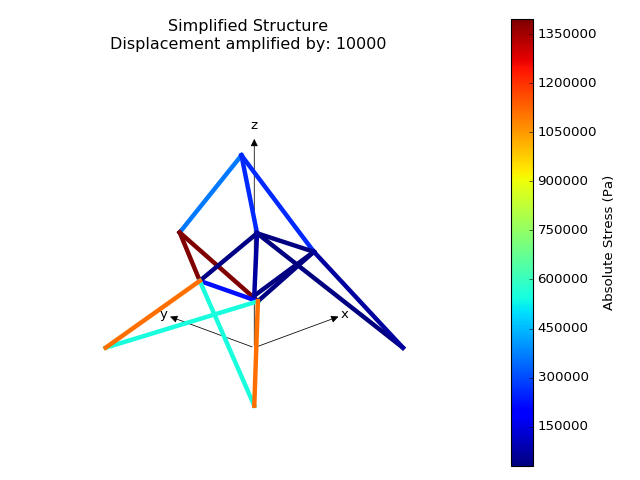

In [30]:
# Inspired from 
# http://stackoverflow.com/questions/26545897/drawing-a-colorbar-aside-a-line-plot-using-matplotlib

fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')

good_elems = np.array([1, 7, 6, 8, 9, 17, 16, 24, 25, 23, 22, 12, 10, 13, 11, 15, 14]) - 1
amp = 10000
# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
SS = np.abs(S)
# xtrm = np.abs(SS[good_elems]).max()
norm1 = matplotlib.colors.Normalize(vmin=-SS.max(), vmax=SS.max())
norm2 = matplotlib.colors.Normalize(vmin=SS.min(),vmax=SS.max())


# choose a colormap
# c_m = matplotlib.cm.bwr
# c_m = matplotlib.cm.winter
c_m1 = matplotlib.cm.RdYlBu
c_m2 = matplotlib.cm.jet

# create a ScalarMappable and initialize a data structure
s_m1 = matplotlib.cm.ScalarMappable(cmap=c_m1, norm=norm1)
s_m1.set_array([])
s_m2 = matplotlib.cm.ScalarMappable(cmap=c_m2, norm=norm2)
s_m2.set_array([])

# for elem in range(num_elems):
for elem in range(num_elems):
    nodes = connectivity[elem]
    old_locs = all_node_locs[nodes] # 2 x 3
    
    mk_beams(ax1, old_locs)
#     mk_beams(ax2, old_locs)
    
    sctr = mk_sctr(nodes)
    disp = U[sctr].reshape((2, 3))
    new_locs = old_locs + disp*amp
#     color1 = s_m1.to_rgba(S[elem])
    color1 = sgn_map(S[elem])
    color2 = s_m2.to_rgba(SS[elem])
    mk_beams(ax1, new_locs, color1)
    if elem in good_elems:
        mk_beams(ax2, new_locs, color2)
    
# cb1 = fig1.colorbar(s_m1)
# cb1.set_label('Stress (Pa)')
cb2 = fig2.colorbar(s_m2)
cb2.set_label('Absolute Stress (Pa)')

applied_node = 0
old_loc = all_node_locs[0]
new_loc = old_loc + U[0:3]*10000
# Coordinate System
mk_arrows(ax1, all_node_locs, do_y=False)
mk_arrows(ax2, all_node_locs)

ax1.grid(False)
ax1.set_axis_off()
ax2.grid(False)
ax2.set_axis_off()

ax1.set_title('Blue: Tension -- Red: Compression\nDisplacement amplified by: %i' % amp)
ax2.set_title('Simplified Structure\nDisplacement amplified by: %i' % amp)

# ax.view_init(35.624, 45)  # Isometric 
ax1.view_init(0, -90)
ax2.view_init(20, -135)
ax1.autoscale()
ax2.autoscale()
fig1.tight_layout()
fig2.tight_layout()

In [31]:
def mk_line(name, vals):
    return ' & '.join([name,] + vals) + ' \\\\'

In [32]:
def find_close(arr, val):
    """Returns a mask."""
    tol = 1e-4
    d = np.abs(arr - val)/np.abs(val)
    return d <= tol

In [41]:
# Make table of displacements
tablehead = r'''\begin{tabular}{@{} r c c c @{}}
    \toprule
    Node & $U_x$ (mm) & $U_y$ (mm) & $U_z$ (mm) \\
    \midrule
'''
tablefoot = r'''
    \bottomrule
\end{tabular}'''
lines = []
Un = U.reshape((num_nodes, ndims))*1000
FMT = '%8.4f'
for node in range(num_nodes):
    disps = Un[node]
    name = '%2i' % (node+1)
    vals = [FMT % d for d in disps]
    line = mk_line(name, vals)
    lines.append(line)

max_ids = []
min_ids = []
max_vals = []
min_vals = []

# UextrmIDs = np.zeros((2, ndims))
# Uextrmvals = np.zeros_like(UextrmIDs)
names = ['Maximum', 'Minimum']
nodeIDs = np.arange(len(Un))
for i in range(ndims):
    max_val = Un[:,i].max()
    max_vals.append(max_val)
    max_mask = find_close(Un[:,i], max_val)
    min_val = Un[:,i].min()
    min_vals.append(min_val)
    min_mask = find_close(Un[:,i], min_val)
    max_ids.append(nodeIDs[max_mask])
    min_ids.append(nodeIDs[min_mask])
#     maxidx = Un[:,i].argmax()
#     minidx = Un[:,i].argmin()
#     UextrmIDs[0, i] = maxidx
#     UextrmIDs[1, i] = minidx
#     Uextrmvals[0, i] = Un[maxidx,i]
#     Uextrmvals[1, i] = Un[minidx,i]

lines.append(r'\midrule')
extrm_ids = [max_ids, min_ids]
extrm_vals = [max_vals, min_vals]
for i in range(2):
    name = names[i]
    vals = [ ', '.join([FMT % d for d in [ds]]) for ds in extrm_vals[i]]
    vals = [FMT % d for d in extrm_vals[i]]
    line = mk_line(name, vals)
    lines.append(line)
#     name = 'Node \#'
    vals = []
    for direc in range(3):
        vals.append(', '.join( ['%i' % (j+1) for j in extrm_ids[i][direc]] ))
    line = mk_line('Node', vals)
    lines.append(line)
    
body = '\n'.join(lines)
utable = '\n'.join([tablehead, body, tablefoot])
print(utable)

\begin{tabular}{@{} r c c c @{}}
    \toprule
    Node & $U_x$ (mm) & $U_y$ (mm) & $U_z$ (mm) \\
    \midrule

 1 &  -0.1476 &  -0.0000 &  -0.1362 \\
 2 &  -0.1376 &  -0.0000 &   0.0125 \\
 3 &   0.0089 &   0.0031 &  -0.0764 \\
 4 &   0.0100 &   0.0005 &   0.0019 \\
 5 &   0.0100 &  -0.0005 &   0.0019 \\
 6 &   0.0089 &  -0.0031 &  -0.0764 \\
 7 &   0.0000 &   0.0000 &   0.0000 \\
 8 &   0.0000 &   0.0000 &   0.0000 \\
 9 &   0.0000 &   0.0000 &   0.0000 \\
10 &   0.0000 &   0.0000 &   0.0000 \\
\midrule
Maximum &   0.0100 &   0.0031 &   0.0125 \\
Node & 4, 5 & 3 & 2 \\
Minimum &  -0.1476 &  -0.0031 &  -0.1362 \\
Node & 1 & 6 & 1 \\

    \bottomrule
\end{tabular}


In [44]:
# Make stress table
tablehead = r'''\begin{tabular}{@{} r c @{}}
    \toprule
    Element & Stress (KPa) \\
    \midrule
'''
tablefoot = r'''
    \bottomrule
\end{tabular}'''
lines = []
FMT = '%7.1f'
Sn = S/(10**3)
for elem in range(num_elems):
    name = '%2i' % (elem+1)
    vals = [FMT % Sn[elem]]
    line = mk_line(name, vals)
    lines.append(line)

lines.append(r'\midrule')
elemIDs = np.arange(num_elems)
max_val = Sn.max()
max_mask = find_close(Sn, max_val)
min_val = Sn.min()
min_mask = find_close(Sn, min_val)
max_ids = elemIDs[max_mask]
min_ids = elemIDs[min_mask]
names = ['Maximum', 'Minimum']

extrm_ids = [max_ids, min_ids]
extrm_val = [max_val, min_val]
for i in range(2):
    name = names[i]
    vals = [FMT % extrm_val[i]]
    line = mk_line(name, vals)
    lines.append(line)
    name = 'Element'
    vals = [', '.join( ['%2i' % (j+1) for j in extrm_ids[i]] )]
    line = mk_line(name, vals)
    lines.append(line)
    
body = '\n'.join(lines)
stable = '\n'.join([tablehead, body, tablefoot])
print(stable)

\begin{tabular}{@{} r c @{}}
    \toprule
    Element & Stress (KPa) \\
    \midrule

 1 &   362.2 \\
 2 &  -315.1 \\
 3 &  -315.1 \\
 4 &  -315.1 \\
 5 &  -315.1 \\
 6 &   257.9 \\
 7 &   257.9 \\
 8 & -1397.5 \\
 9 & -1397.5 \\
10 &   221.6 \\
11 &    34.1 \\
12 &    40.4 \\
13 &    40.4 \\
14 &  -551.7 \\
15 &  -551.7 \\
16 &   -30.8 \\
17 &   -30.8 \\
18 &   127.4 \\
19 &  -750.0 \\
20 &   127.4 \\
21 &  -750.0 \\
22 & -1109.6 \\
23 & -1109.6 \\
24 &   -71.2 \\
25 &   -71.2 \\
\midrule
Maximum &   362.2 \\
Element &  1 \\
Minimum & -1397.5 \\
Element &  8,  9 \\

    \bottomrule
\end{tabular}


In [38]:
import os
import subprocess
from IPython.display import Image

In [39]:
def preview(table):
    tex = r'''\documentclass{article}
    \usepackage{booktabs}
    \begin{document}
    \begin{table}
    \centering
    %s
    \end{table}
    \end{document}
    ''' % table
    if not os.path.exists('textemp'):
        os.mkdir('textemp')
    open('textemp/main.tex', 'w').write(tex)
#     os.chdir('textemp')
    print(subprocess.check_output(['pdflatex', 'main.tex'], cwd='textemp'))
    print(subprocess.check_output(['evince', 'textemp/main.pdf']))
#     os.chdir('..')

In [45]:
preview(stable)

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./main.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/booktabs/booktabs.sty) (./main.aux)
[1{/var/lib/texmf/fonts/map/pdftex/updmap/pdftex.map}] (./main.aux) )</usr/shar
e/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmr10.pfb>
Output written on main.pdf (1 page, 16648 bytes).
Transcript written on main.log.


